# Generative Models

## Diffusion Models

By Alireza Heidari

In this notebook, we are going to implement Denoising Diffusion Probabilistic Model (DDPM) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each generative model.

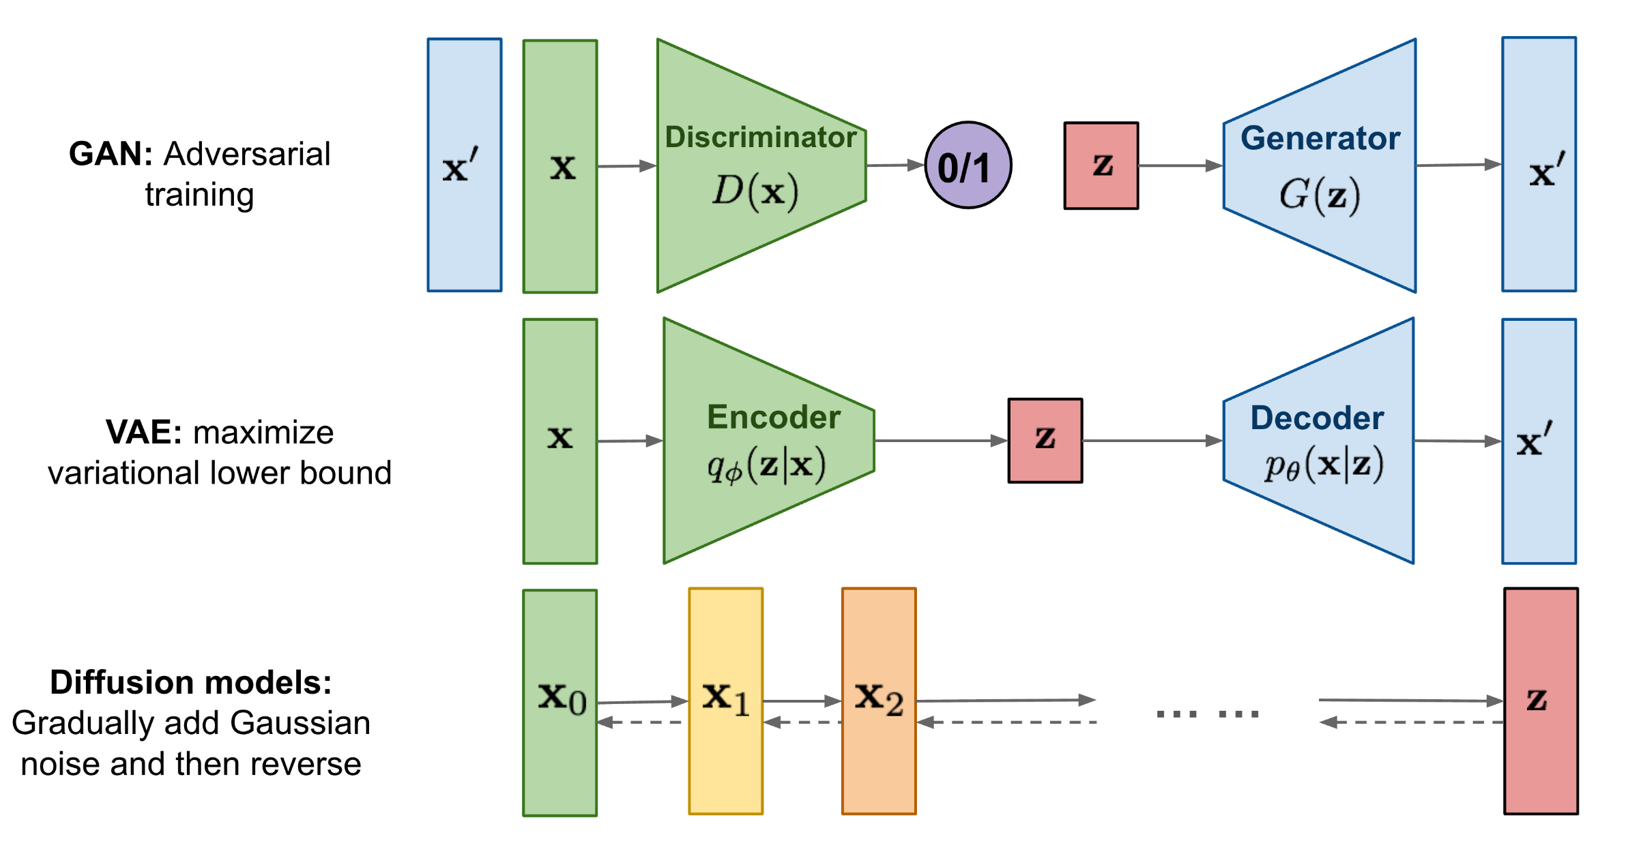 

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images (e.g. iteratively denoised images by DDPM).

### Initialization

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm import tqdm

BATCH_SIZE = 20
IMG_SIZE = 32 
C_IN = 1 # Number of input channels

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [2]:
DEVICE

'cuda'

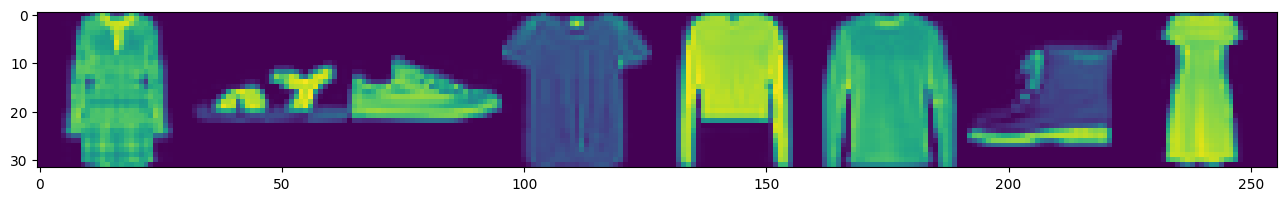

In [3]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

### DDPM (Denoising Diffusion Probabilistic Model)

Denoising diffusion probabilistic models (DDPMs) learn to generate images by gradually denoising a completely random pattern in a step-by-step process. The model learns a set of diffusion steps that describe how the noise evolves through time and a denoising function that removes the noise at each time step. The denoising function is typically implemented as a neural network that takes in the noisy data and the time step as input and outputs the denoised data. After iterative denoising steps over a time index, an image from the training distribution is generated. The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.

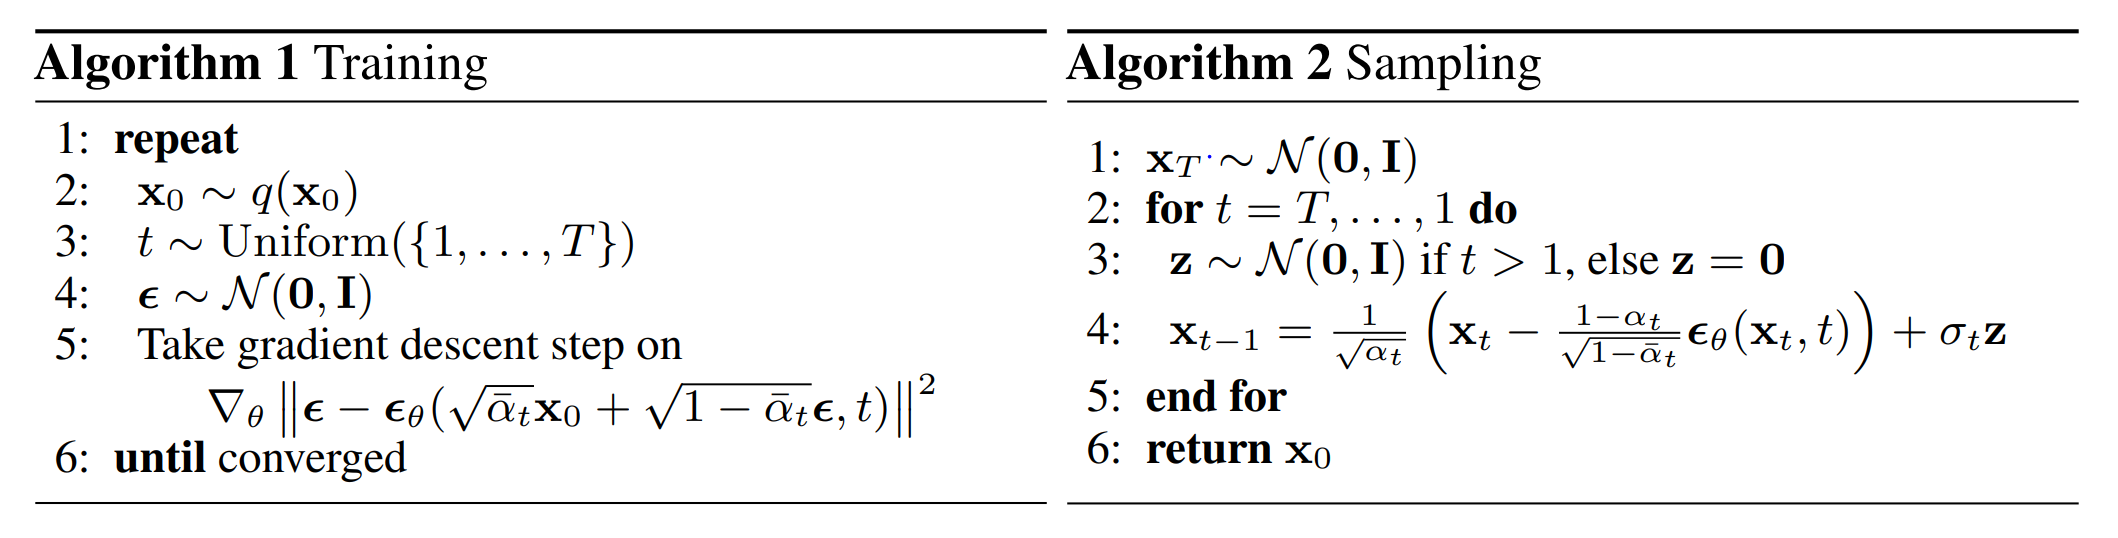

The pseudocode shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the architecture proposed by the paper, a UNet with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules, etc. We describe the expected architecture for this notebook:

+ *ResNet:* As a base sub-module, we define each ResNet block as two consecutive convolutional layers with a GELU activation in between and Group Normalization after each convolutional layer. You can use this module in Down/Up blocks. Also, by removing the residual connection, you can use this block as a convolutional network throughout the network.
+ *Attention:* This is also a sub-module consisting of a Layer Normalization, Multi-head Attention (use from `torch.nn`), a residual connection, a feed-forward network, and another residual connection.
+ *Conditional UNet:* Each Up/Down block in UNet accepts positionally-encoded time as an input. The time index is encoded and added to the output of the block. You can use the sinusoidal position embeddings proposed in [Attention is All You Need.](https://arxiv.org/pdf/1706.03762.pdf)

I have implemented the following structure for UNet:

+ Convolutional block
+ Down block
+ Attention 
+ Down block
+ Attention
+ Down block
+ Attention

+ Convolutional block (bottleneck)
+ Convolutional block (bottleneck)

+ Up block
+ Attention
+ Up block
+ Attention
+ Up block
+ Attention
+ Convolutional block

### Modules

In [4]:
class ConvResNet(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )
        
        self.gelu = nn.GELU()

    def forward(self, x):
        if self.residual:
            return self.gelu(x + self.double_conv(x))
        else:
            return self.gelu(self.double_conv(x))

class Attention(nn.Module):
    def __init__(self, h_size, num_s):
        super().__init__()
        self.num_s = num_s
        self.h_size = h_size
        self.multi_head_att = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.layer_norm = nn.LayerNorm([h_size])
        self.fc = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x_normed = self.layer_norm(x)
        context, _ = self.multi_head_att(x_normed, x_normed, x_normed)
        context = context + x
        context = self.fc(context) + context
        context = context.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return context
        
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            ConvResNet(in_channels, in_channels, residual=True),
            ConvResNet(in_channels, out_channels),
        )
        self.max_pool = nn.MaxPool2d(2)

    def forward(self, x):
        skip = self.conv(x)
        out = self.max_pool(skip)
        return out, skip

    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.up_sample = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=(2, 2), stride=2, padding=0)
        self.conv = ConvResNet(in_channels, in_channels, residual=True)
        self.conv2 = ConvResNet(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up_sample(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x

    
class OutputConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutputConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

def pos_encoding(t, channels, embed_size):
    inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device=DEVICE).float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    
    return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvResNet(1, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        
        self.bottleneck = nn.Sequential(
            ConvResNet(128, 128),
            ConvResNet(128, 256),
        )

        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.up3 = Up(64, 32)
        
        self.out_conv = OutputConv(32, 1)
        
        self.att1 = Attention(32, 16)
        self.att2 = Attention(64, 8)
        self.att3 = Attention(128, 4)
        
        self.att4 = Attention(128, 8)
        self.att5 = Attention(64, 16)
        self.att6 = Attention(32, 32)

    def forward(self, x, t):
        x1 = self.conv1(x)
        x2, x2_skip = self.down1(x1) 
        x3 = self.att1(x2 + pos_encoding(t, 32, 16))
        x4, x4_skip = self.down2(x3)  
        x5 = self.att2(x4 + pos_encoding(t, 64, 8))
        x6, x6_skip = self.down3(x5) 
        x7 = self.att3(x6 + pos_encoding(t, 128, 4))
        
        x8 = self.bottleneck(x7)
        
        x9 = self.up1(x8, x6_skip)
        x10 = self.att4(x9 + pos_encoding(t, 128, 8))
        x11 = self.up2(x10, x4_skip)
        x12 = self.att5(x11 + pos_encoding(t, 64, 16))
        x13 = self.up3(x12, x2_skip)
        x14 = self.att6(x13  + pos_encoding(t, 32, 32))
        
        output = self.out_conv(x14)
        return output

### Training

In [5]:
class DDPMManager():
    def __init__(self):
        self.in_size = 32 * 32
        self.T = 1000
        self.beta_small = 1e-4
        self.beta_large = 0.025
        
        t = np.linspace(0, self.T, self.T)
        self.betas = torch.tensor(-1 * np.cos(math.pi * t / (2 * self.T)) * (self.beta_large - self.beta_small) + self.beta_large, dtype=torch.float32, device=DEVICE)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(DEVICE)
        self.unet = UNet()
        self.unet.to(DEVICE)
        self.optimizer = torch.optim.Adam(self.unet.parameters(), lr=0.0002)
        self.lr_scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    def train(self, dataloader, epochs):
        history = dict(loss=[])
        for epoch in range(epochs):
            total_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)
                ts = torch.randint(0, self.T, [batch_x.shape[0]], device=DEVICE)
                noise_imgs = []
                epsilons = torch.randn(batch_x.shape, device=DEVICE)
                for i in range(len(ts)):
                    alpha_bar = self.alpha_bars[ts[i]]
                    noise_imgs.append(
                        (math.sqrt(alpha_bar) * batch_x[i]) + (math.sqrt(1 - alpha_bar) * epsilons[i])
                    )
    
                noise_imgs = torch.stack(noise_imgs, dim=0)

                e_hat = self.unet(noise_imgs, ts.unsqueeze(-1).type(torch.float))

                loss = nn.functional.mse_loss(
                    e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
                )
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)
            self.lr_scheduler.step(mean_loss)
            print(
                "[Epoch: %d/%d] [loss: %.4f]"
                % (epoch+1, epochs, mean_loss)
            )
            if epoch % 2:
                self.sample(8, plot=True)

            history['loss'].append(mean_loss)

        return history
    
    def sample(self, n, plot=True):
        with torch.no_grad():
            x = torch.randn(1, 1, 32, 32, device=DEVICE)
            xs = []
            for t in reversed(range(self.T)):
                alpha_bar_t = self.alpha_bars[t]
                epsilons = torch.randn(1, 1, 32, 32, device=DEVICE) if t != 0 else torch.zeros(1, 1, 32, 32, device=DEVICE)
                
                e_hat_t = self.unet(x, t * torch.ones(1, device=DEVICE))
                
                x = 1/math.sqrt(self.alphas[t]) * (x - (1 - self.alphas[t]) * e_hat_t / math.sqrt(1- self.alpha_bars[t]))
                x += math.sqrt(self.betas[t]) * epsilons
                if (t+1) % 150 == 0 or t == 0 or t == (self.T - 1):
                    xs.append(x.clone().cpu().reshape(1, 1, 32, 32))
            xs = torch.cat(xs, dim=0)  # Concatenate tensors along the batch dimension
            xs = xs.reshape(n, 1, 32, 32)  # Reshape xs to have the desired shape
            if plot:
                plot_images(xs)
            return x

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 1/35] [loss: 0.0967]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 2/35] [loss: 0.0576]


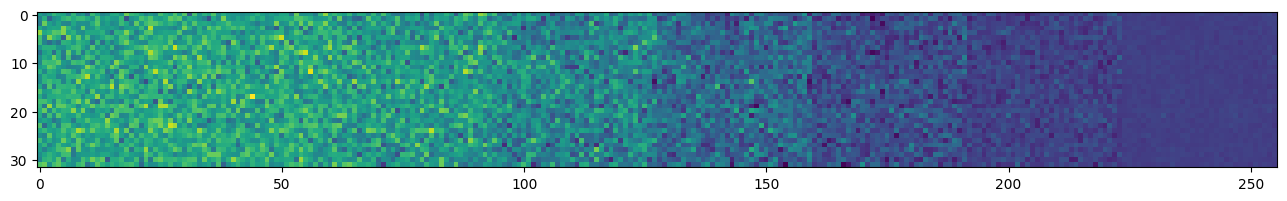

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 3/35] [loss: 0.0520]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 4/35] [loss: 0.0494]


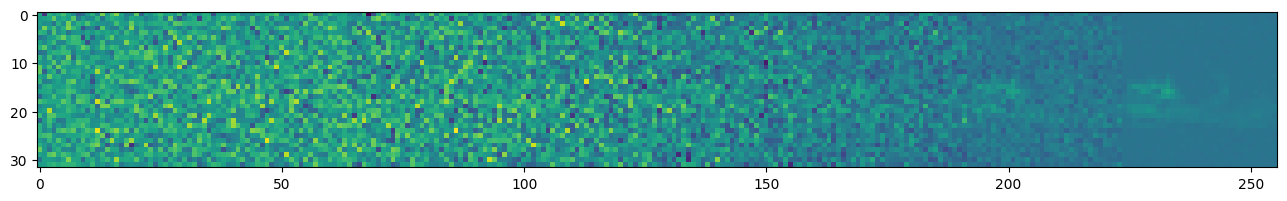

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 5/35] [loss: 0.0470]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 6/35] [loss: 0.0465]


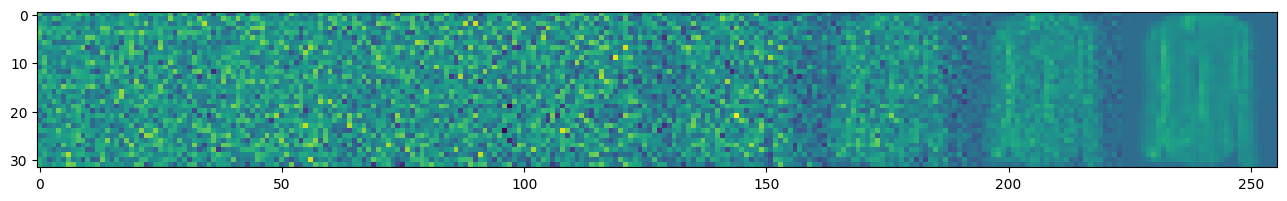

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 7/35] [loss: 0.0452]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 8/35] [loss: 0.0446]


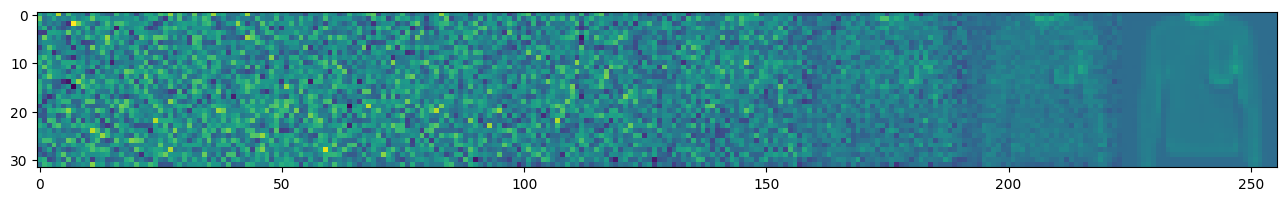

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 9/35] [loss: 0.0440]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 10/35] [loss: 0.0436]


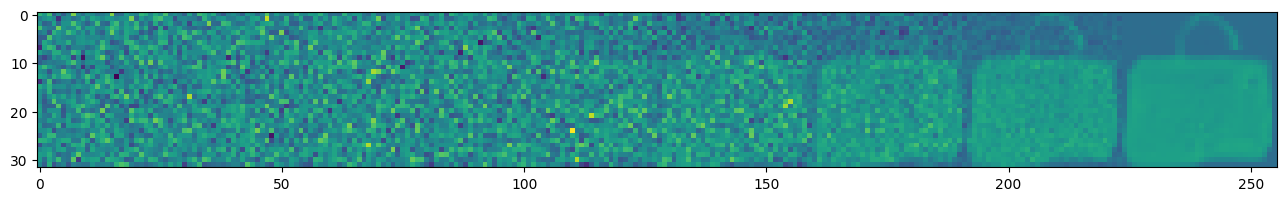

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 11/35] [loss: 0.0435]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 12/35] [loss: 0.0427]


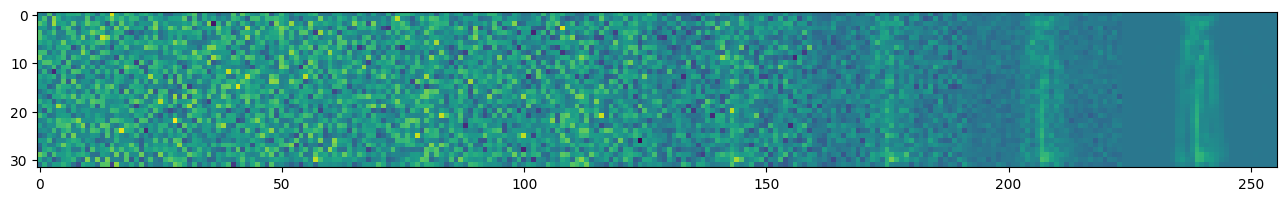

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 13/35] [loss: 0.0426]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 14/35] [loss: 0.0424]


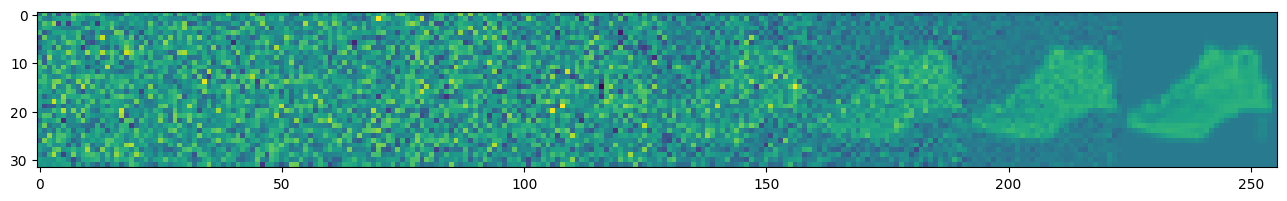

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 15/35] [loss: 0.0420]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 16/35] [loss: 0.0425]


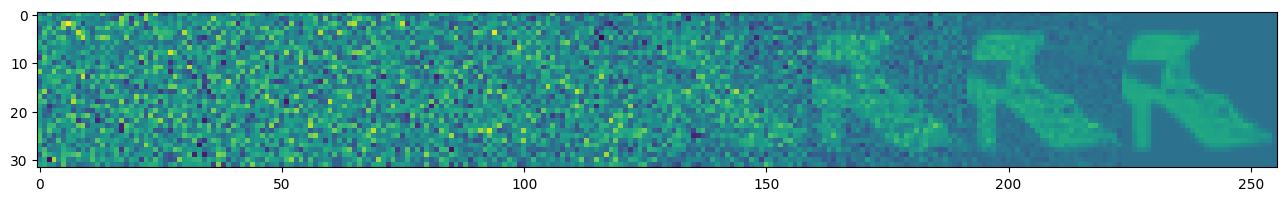

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 17/35] [loss: 0.0417]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 18/35] [loss: 0.0417]


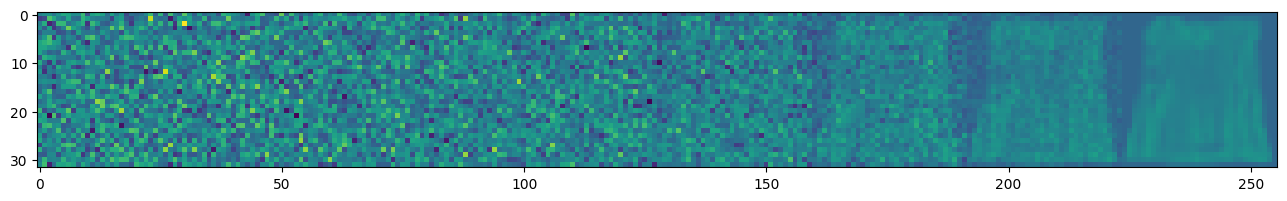

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 19/35] [loss: 0.0415]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 20/35] [loss: 0.0408]


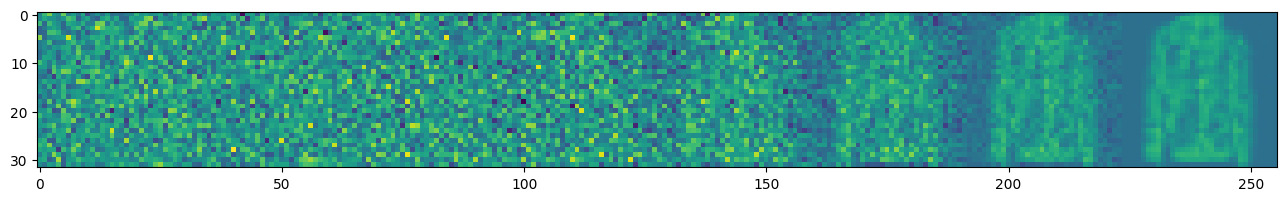

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 21/35] [loss: 0.0413]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 22/35] [loss: 0.0406]


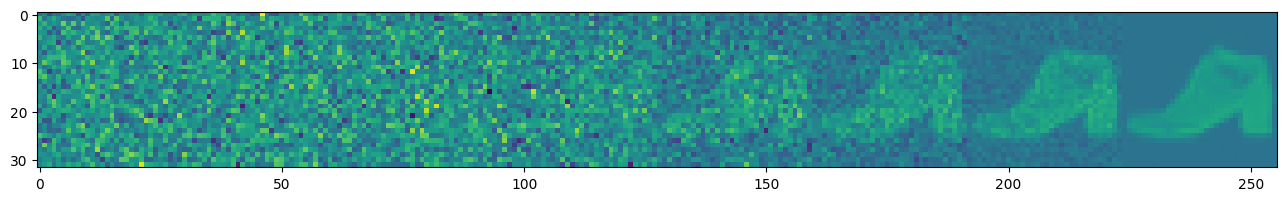

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 23/35] [loss: 0.0411]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 24/35] [loss: 0.0408]


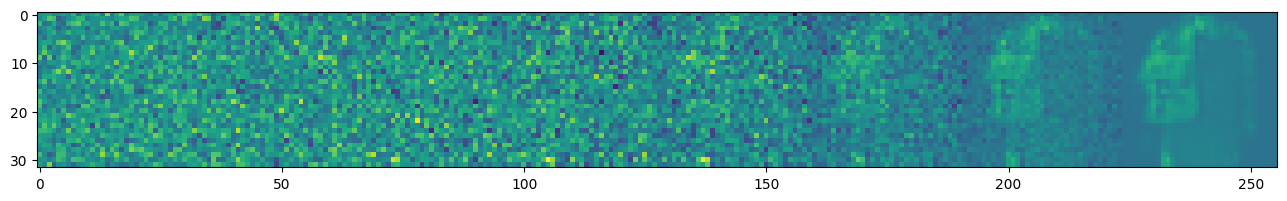

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 25/35] [loss: 0.0404]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 26/35] [loss: 0.0410]


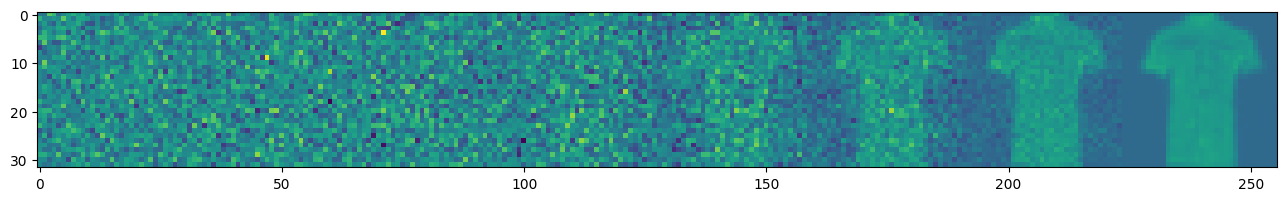

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 27/35] [loss: 0.0405]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 28/35] [loss: 0.0407]


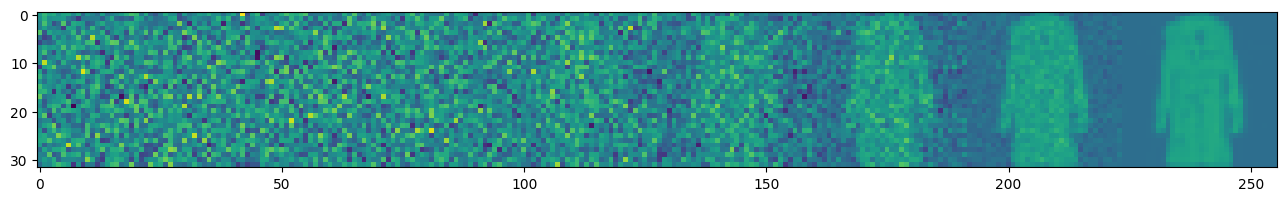

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 29/35] [loss: 0.0406]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 30/35] [loss: 0.0404]


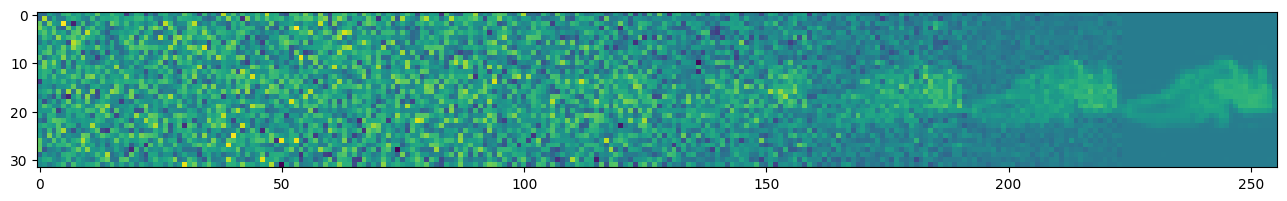

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 31/35] [loss: 0.0404]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 32/35] [loss: 0.0403]


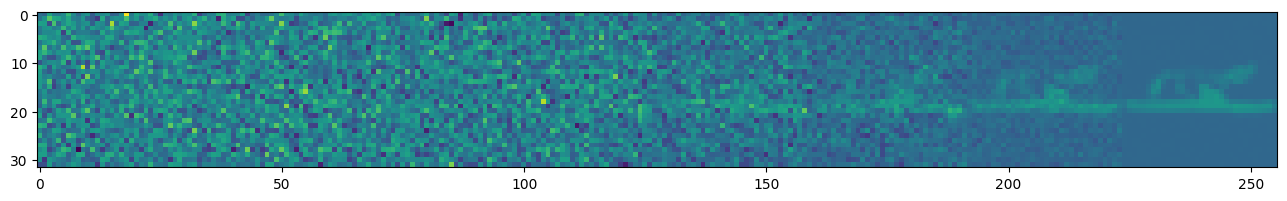

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 33/35] [loss: 0.0400]


  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 34/35] [loss: 0.0400]


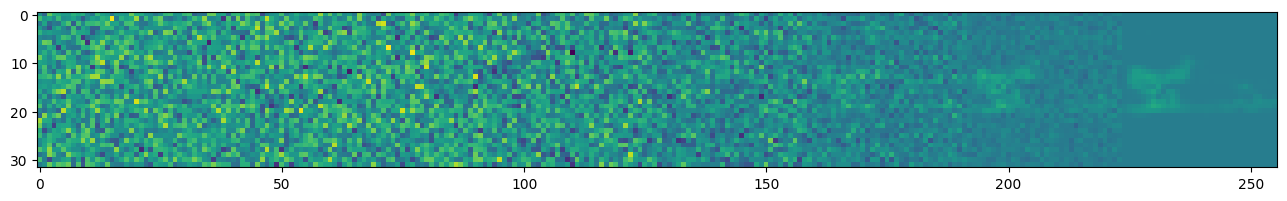

  0%|          | 0/3750 [00:00<?, ?it/s]

[Epoch: 35/35] [loss: 0.0399]


In [7]:
ddpm = DDPMManager() # You can pass your arguments to the call.
ddpm_history = ddpm.train(dataloader, epochs=35)

### Visualize Loss

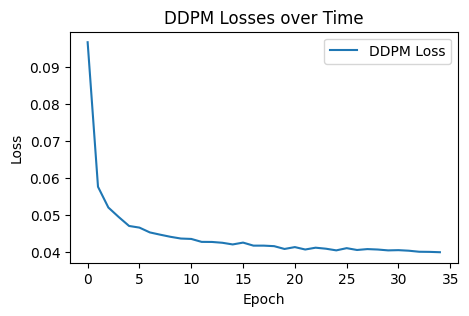

In [8]:
import matplotlib.pyplot as plt

def plot_losses(ddpm_history):
    figsize = (5, 3)    
    plt.figure(figsize=figsize)
    plt.plot(ddpm_history['loss'], label='DDPM Loss')
    plt.title('DDPM Losses over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(ddpm_history)